# Brain Tumor Classification Pipeline

## Imports

In [1]:
# system modules
import os
import itertools
from PIL import Image

In [2]:
# preprocessing modules
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# deep learning modules
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam, Adamax

import warnings
warnings.filterwarnings('ignore')

## Preprocessing

### Training Data

In [4]:
# path to training data directory
trainingdata_path = os.path.normpath("/kaggle/input/brain-tumor-mri-dataset/Training")

# initialize lists to store paths of images and their labels
img_paths = []
labels = []

# directories -> lists
training_directory = os.listdir(trainingdata_path)

In [5]:
# get paths and labels of classes and images in training directory
for i in training_directory:
    class_path = os.path.join(trainingdata_path, i)
    img_list = os.listdir(class_path)

    for img in img_list:
        img_path = os.path.join(class_path, img)
        img_paths.append(img_path)
        labels.append(i)

In [6]:
# convert lists of img_Paths and their labels into Pandas Series
paths = pd.Series(img_paths, name="path")
labels = pd.Series(labels, name="label")

# concatenate into one Pandas Dataframe
train_data = pd.concat([paths, labels], axis=1)

In [7]:
train_data.shape

(5712, 2)

In [8]:
train_data.head()

path      label
0  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
1  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
2  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
3  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
4  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary

In [9]:
train_data.tail()

path   label
5707  /kaggle/input/brain-tumor-mri-dataset/Training...  glioma
5708  /kaggle/input/brain-tumor-mri-dataset/Training...  glioma
5709  /kaggle/input/brain-tumor-mri-dataset/Training...  glioma
5710  /kaggle/input/brain-tumor-mri-dataset/Training...  glioma
5711  /kaggle/input/brain-tumor-mri-dataset/Training...  glioma

In [10]:
train_data.describe()

path    label
count                                                5712     5712
unique                                               5712        4
top     /kaggle/input/brain-tumor-mri-dataset/Training...  notumor
freq                                                    1     1595

### Test Data

In [11]:
# path to test data directory
testingdata_path = os.path.normpath("/kaggle/input/brain-tumor-mri-dataset/Testing")

# initialize lists to store paths of images and their labels
img_paths = []
labels = []

# directories -> lists
testing_directory = os.listdir(testingdata_path)

In [12]:
# get paths and labels of classes and images in testing directory
for i in testing_directory:
    class_path = os.path.join(testingdata_path, i)
    img_list = os.listdir(class_path)

    for img in img_list:
        img_path = os.path.join(class_path, img)
        img_paths.append(img_path)
        labels.append(i)

In [13]:
# convert lists of img_Paths and their labels into Pandas Series
paths = pd.Series(img_paths, name="path")
labels = pd.Series(labels, name="label")

# concatenate into one Pandas Dataframe
test_data = pd.concat([paths, labels], axis=1)

In [14]:
test_data.shape

(1311, 2)

In [15]:
test_data.head()

path      label
0  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
1  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
2  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
3  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
4  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary

In [16]:
test_data.tail()

path   label
1306  /kaggle/input/brain-tumor-mri-dataset/Testing/...  glioma
1307  /kaggle/input/brain-tumor-mri-dataset/Testing/...  glioma
1308  /kaggle/input/brain-tumor-mri-dataset/Testing/...  glioma
1309  /kaggle/input/brain-tumor-mri-dataset/Testing/...  glioma
1310  /kaggle/input/brain-tumor-mri-dataset/Testing/...  glioma

In [17]:
test_data.describe()

path    label
count                                                1311     1311
unique                                               1311        4
top     /kaggle/input/brain-tumor-mri-dataset/Testing/...  notumor
freq                                                    1      405

In [18]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1311 entries, 0 to 1310
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    1311 non-null   object
 1   label   1311 non-null   object
dtypes: object(2)
memory usage: 20.6+ KB


### Split Test Data into Validation and Test Set

In [19]:
# split test data in half to a validation and test set using train_test split
# shuffled since originally ordered by tumor classification
validation_dataframe, testing_dataframe = train_test_split(test_data, train_size = 0.5, shuffle = True, random_state = 123)
print("Test Set shape:", testing_dataframe.shape)
print("Validation Set shape:", validation_dataframe.shape)

Test Set shape: (656, 2)
Validation Set shape: (655, 2)


### Create Image Generators

In [20]:
# hyperparameters
batch_size = 20
img_size = (224,224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# initialize generators
train_image_generator = ImageDataGenerator(fill_mode='nearest')
validation_image_generator = ImageDataGenerator()
testing_image_generator = ImageDataGenerator()

### Generate New Data for Fitting into Model

In [21]:
train = train_image_generator.flow_from_dataframe(train_data, x_col = 'path', y_col = 'label', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)

Found 5712 validated image filenames belonging to 4 classes.


In [22]:
test = testing_image_generator.flow_from_dataframe(testing_dataframe, x_col = 'path', y_col = 'label', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 656 validated image filenames belonging to 4 classes.


In [23]:
valid = validation_image_generator.flow_from_dataframe(validation_dataframe, x_col = 'path', y_col = 'label', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)

Found 655 validated image filenames belonging to 4 classes.


### Sample Batch from Training Data

In [24]:
# define labels and their indices in a dictionary
label_index = train.class_indices
label_index

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [25]:
# label list
keys = list(label_index.keys())
keys

['glioma', 'meningioma', 'notumor', 'pituitary']

In [26]:
# get a sample batch
images, labels = next(train)

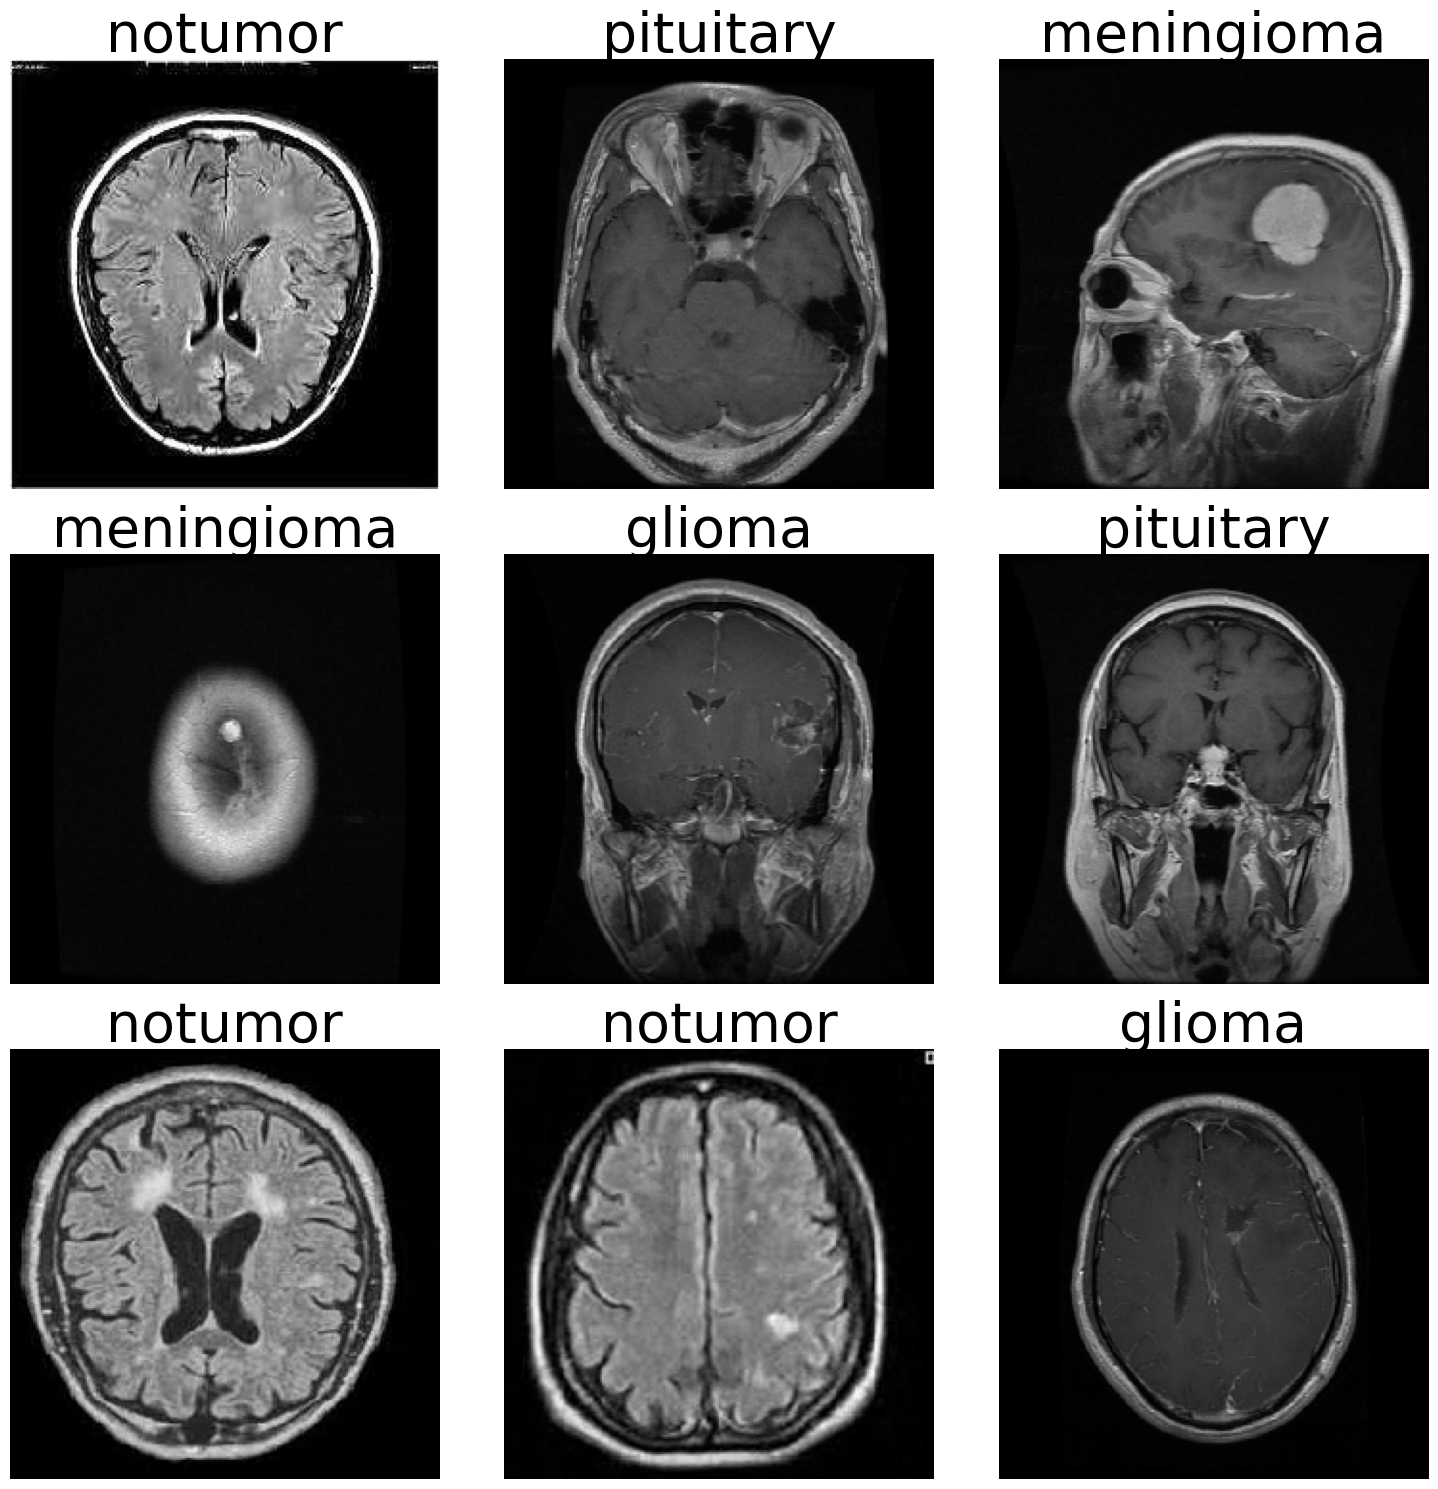

In [27]:
# visualize the batch
plt.figure(figsize= (15, 15))

for i in range(9):
    plt.subplot(3, 3, i +1)
    img = images[i]/255
    plt.imshow(img)
    
    index = np.argmax(labels[i])
    label = keys[index]
    plt.title(label, size=40, color = 'black')
    plt.axis('off')
    
plt.tight_layout()    
plt.show()

### Sample Batch from Validation Data

In [28]:
# use the same label_index and keys

# get a sample batch
images, labels = next(test)

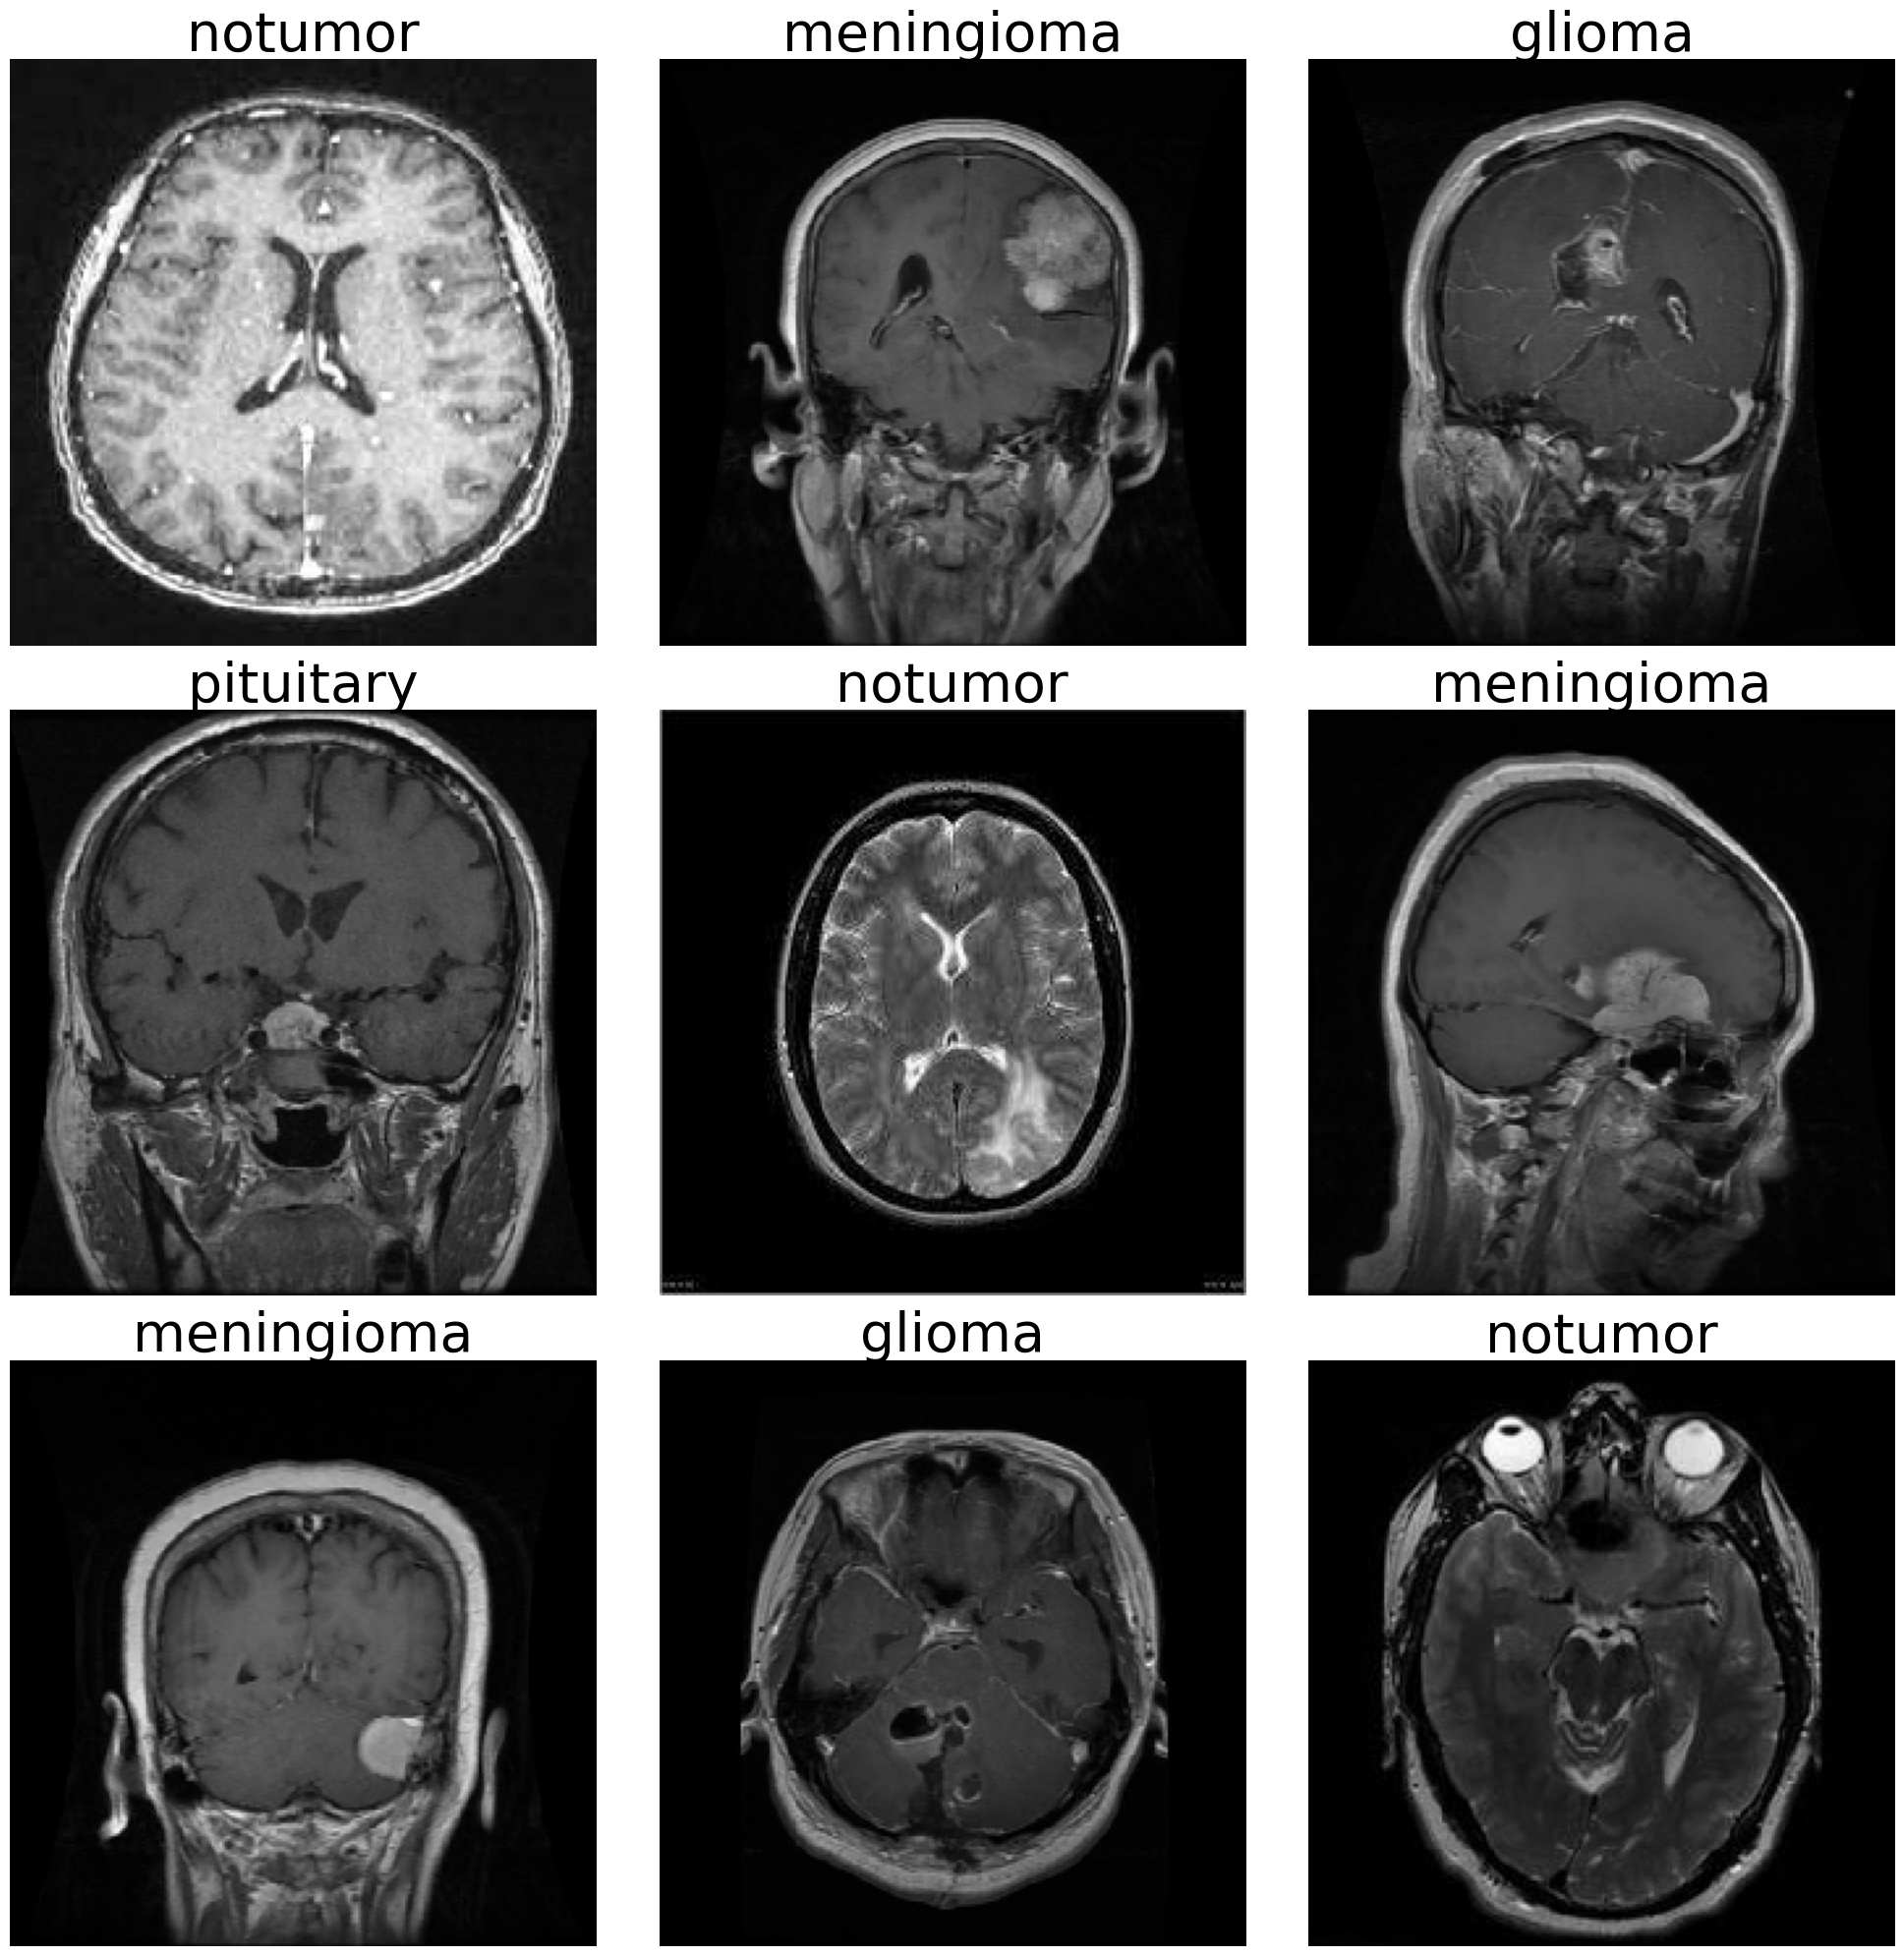

In [29]:
# visualize the batch
plt.figure(figsize= (20, 20))

for i in range(9):
    plt.subplot(3, 3, i +1)
    img = images[i]/255
    plt.imshow(img)
    
    index = np.argmax(labels[i])
    label = keys[index]
    plt.title(label, size=40, color = 'black')
    plt.axis('off')
    
plt.tight_layout()    
plt.show()

### Sample Batch from Test Data

In [30]:
# use the same label_index and keys

# get a sample batch
images, labels = next(test)

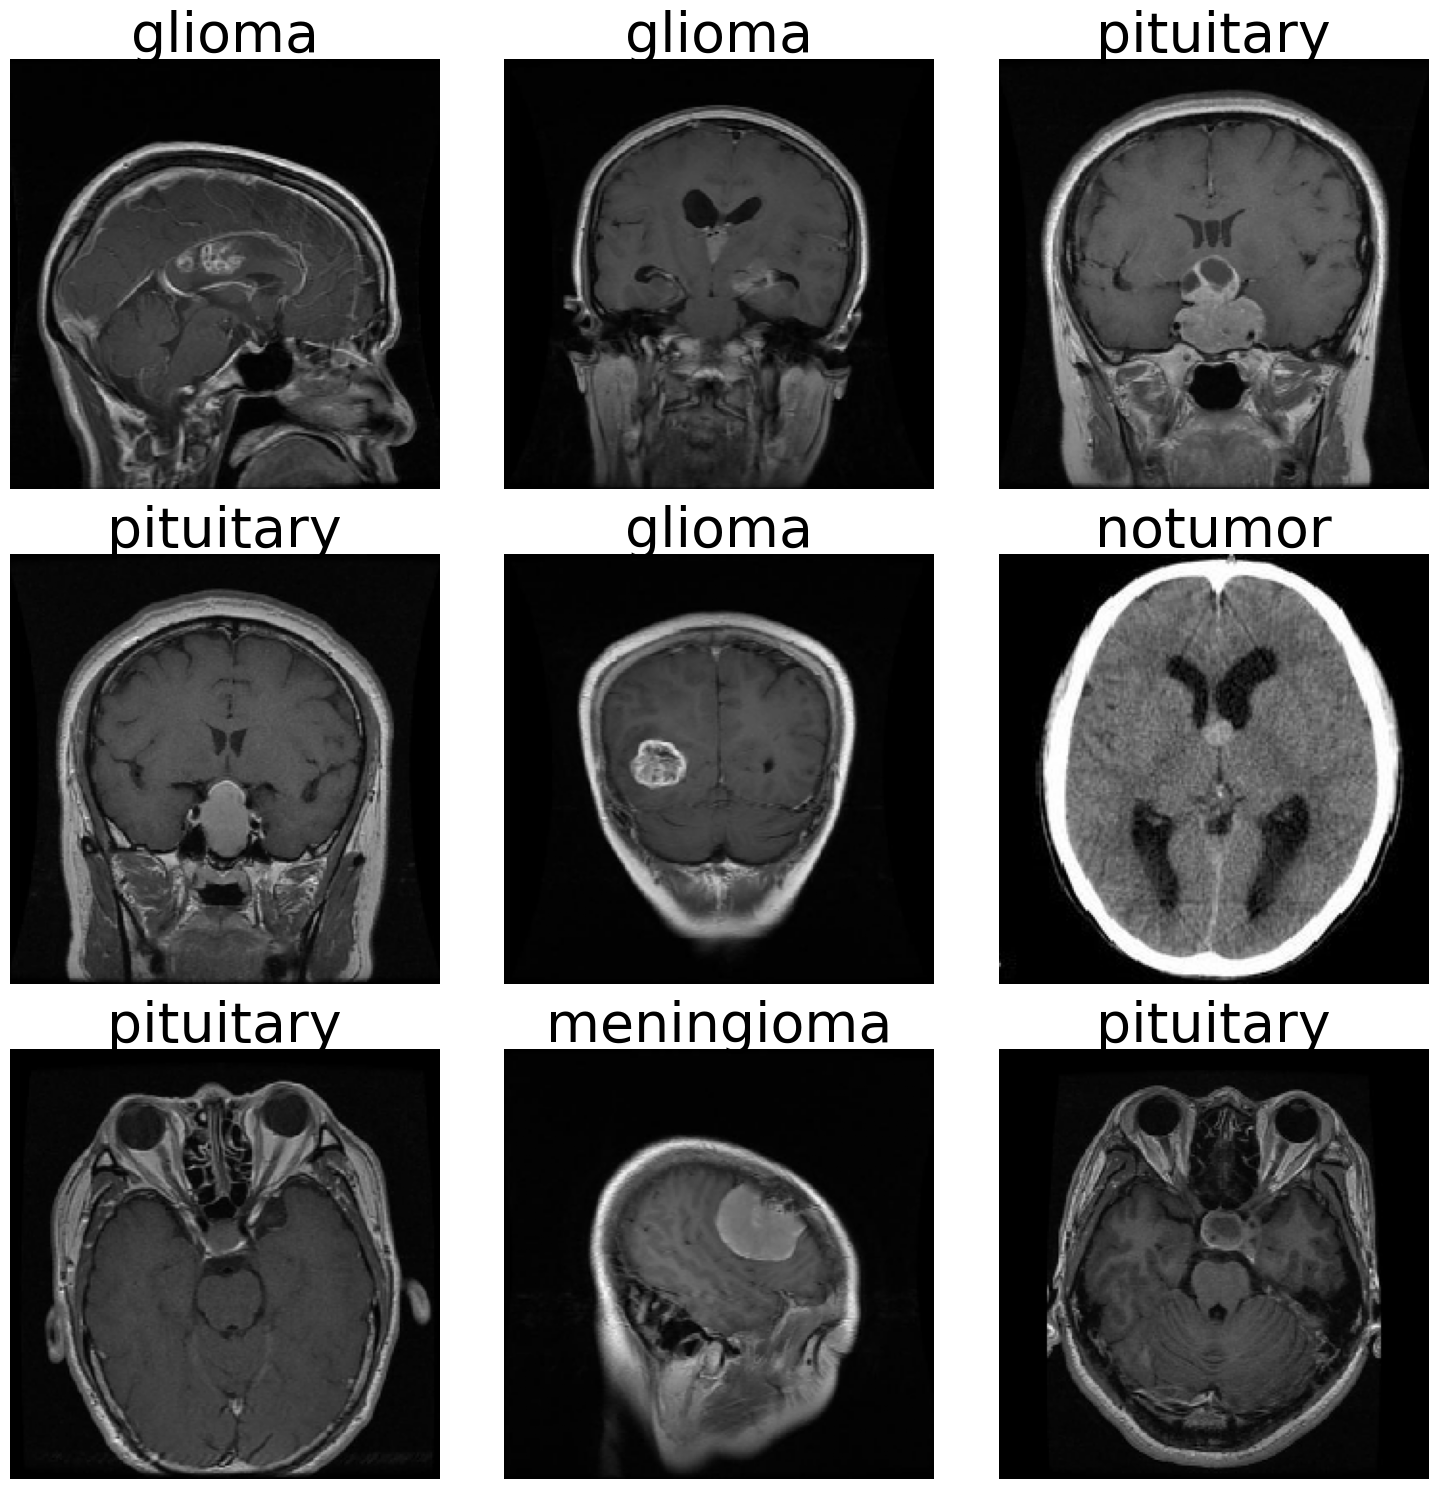

In [31]:
# visualize the batch
plt.figure(figsize= (15, 15))

for i in range(9):
    plt.subplot(3, 3, i +1)
    img = images[i]/255
    plt.imshow(img)
    
    index = np.argmax(labels[i])
    label = keys[index]
    plt.title(label, size=40, color = 'black')
    plt.axis('off')
    
plt.tight_layout()    
plt.show()

## Model Structure

In [32]:
# hyperparameters for CNN
batch_size = 20
img_size = (224,224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

In [33]:
# determine the number of unique classes to set the number of neurons in the final layer.
# each neuron represents the probability of a corresponding class
num_classes = len(list(train.class_indices.keys()))
num_classes

4

In [34]:
CNN = Sequential([
    Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'elu', input_shape = img_shape),
    Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'elu'),
    Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'elu'),
    MaxPooling2D((2,2)),
    
    Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'elu'),
    Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'elu'),
    MaxPooling2D((2,2)),
    
    Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'elu'),
    Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'elu'),
    MaxPooling2D((2,2)),
    
    Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'elu'),
    Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'elu'),
    MaxPooling2D((2,2)),
    
    Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'elu'),
    Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'elu'),
    MaxPooling2D((2,2)),
    
    Flatten(),
    
    Dense(256, activation = 'elu'),
    Dense(128, activation = 'elu'),
    Dense(64, activation = 'elu'),
    Dense(32, activation = 'elu'),
    Dense(num_classes, activation = 'softmax')
])

In [35]:
# the compilation of the model
CNN.compile(optimizer=Adamax(learning_rate=0.001), 
            loss='categorical_crossentropy', 
            metrics=['accuracy'])


In [36]:
CNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 224, 224, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,763,940 (14.36 MB)

 Trainable params: 3,763,940 (14.36 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [37]:
epochs = 15

history = CNN.fit(x=train, epochs=epochs, verbose=1, validation_data=valid, shuffle=False)


Epoch 1/15


I0000 00:00:1733292019.107087      95 service.cc:145] XLA service 0x7ec1800073e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733292019.107141      95 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733292019.107144      95 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733292054.973109      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


286/286 ━━━━━━━━━━━━━━━━━━━━ 275s 824ms/step - accuracy: 0.5702 - loss: 1.4768 - val_accuracy: 0.7206 - val_loss: 0.7321
Epoch 2/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 220s 770ms/step - accuracy: 0.8517 - loss: 0.4114 - val_accuracy: 0.8183 - val_loss: 0.4616
Epoch 3/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 224s 784ms/step - accuracy: 0.9058 - loss: 0.2633 - val_accuracy: 0.7878 - val_loss: 0.5060
Epoch 4/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 226s 789ms/step - accuracy: 0.9068 - loss: 0.2612 - val_accuracy: 0.8672 - val_loss: 0.3437
Epoch 5/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 225s 787ms/step - accuracy: 0.9244 - loss: 0.2084 - val_accuracy: 0.8427 - val_loss: 0.4590
Epoch 6/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 225s 787ms/step - accuracy: 0.9257 - loss: 0.1844 - val_accuracy: 0.9115 - val_loss: 0.2535
Epoch 7/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 225s 788ms/step - accuracy: 0.9520 - loss: 0.1335 - val_accuracy: 0.8962 - val_loss: 0.2738
Epoch 8/15
286/286 ━━━━━━━━━━━━━━━━━━━━ 224s 784ms/step - accuracy: 0.9563 - loss: 0.11

## Model Evaluation

### Metrics

In [38]:
# accuracy and loss on training data
training_acc = history.history['accuracy']
training_loss = history.history['loss']

# validation data accuracy and validation data loss
validation_acc = history.history['val_accuracy']
validation_loss = history.history['val_loss']

# highest value of validation accuracy, and index
index_acc = np.argmax(validation_acc)
high_validation_acc = validation_acc[index_acc]

# lowed value of validation accuracy, and index of where it happened
index_loss = np.argmin(validation_loss)
low_validation_loss = validation_loss[index_loss]

# number of epochs based on length of training accuracy values
epochs =[]
for i in range(len(training_acc)):
    epochs.append (i+1)

# define best epoch
best_acc = f'Best Epoch ={str(index_acc +1)}'
best_loss = f'Best Epoch ={str(index_loss+1)}'

### Visualize

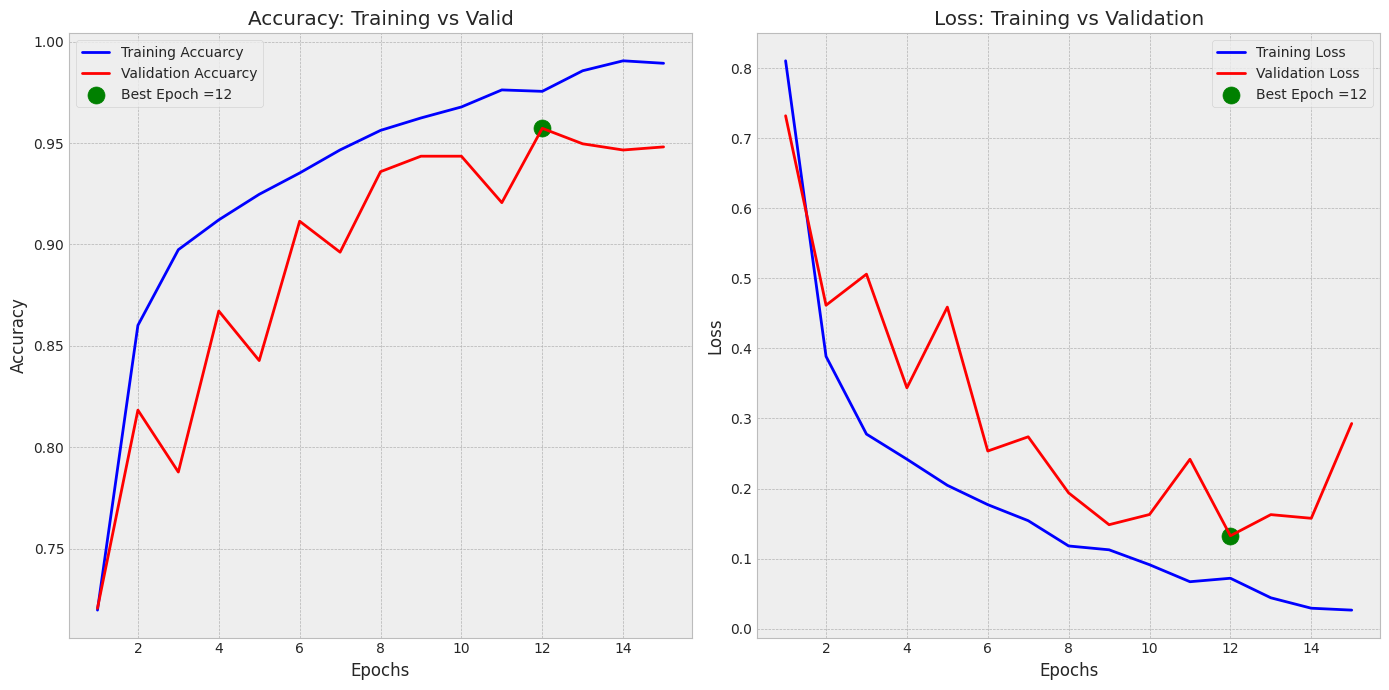

In [39]:
plt.figure(figsize = (14, 7))
plt.style.use('bmh')

plt.subplot(1,2,1)
plt.plot(epochs, training_acc, "b", label = "Training Accuarcy")
plt.plot(epochs, validation_acc, "r", label = "Validation Accuarcy")
plt.scatter(index_acc+1, high_validation_acc, s= 150, color = 'green', label = best_acc)

plt.title("Accuracy: Training vs Valid")
plt. xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, training_loss, "b", label = "Training Loss")
plt.plot(epochs, validation_loss, "r", label = "Validation Loss")
plt.scatter(index_loss+1, low_validation_loss, s= 150, color = 'green', label = best_loss)

plt.title("Loss: Training vs Validation")
plt. xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Get Scores

In [40]:
train_score = CNN.evaluate(train, verbose = 0)
valid_score = CNN.evaluate(valid, verbose = 0)
test_score = CNN.evaluate(test, verbose = 0)

In [49]:
print('____________________________________________________________________')
print(f'   Train Scores:      |   Validation Scores:  |    Test Scores:')
print(f'   Accuracy: {train_score[1]:.4f}   |     Accuracy: {valid_score[1]:.4f}  |     Accuracy: {test_score[1]:.4f}')
print(f'   Loss: {train_score[0]:.4f}       |     Loss: {valid_score[0]:.4f}      |     Loss: {test_score[0]:.4f}')
print('______________________|_______________________|______________________')

____________________________________________________________________
   Train Scores:      |   Validation Scores:  |    Test Scores:
   Accuracy: 0.9918   |     Accuracy: 0.9481  |     Accuracy: 0.9375
   Loss: 0.0375       |     Loss: 0.2928      |     Loss: 0.2897
______________________|_______________________|______________________


## Model Predictions

In [42]:
predictions = CNN.predict(test)
y_pred = np.argmax(predictions, axis = 1)

print("\nPredictions (Probabilities of Each Class):\n", predictions[:5])  # show first 5 predictions
print("\nPredicted Classes (Highest Probable Class):\n", y_pred[:5])  # show first 5 predicted classes

33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 274ms/step

Predictions (Probabilities of Each Class):
 [[2.2467455e-12 1.3479196e-06 9.9999869e-01 1.4285127e-13]
 [4.1077237e-04 9.9958497e-01 4.2521488e-06 1.5933531e-10]
 [1.0000000e+00 1.8599577e-08 1.2200877e-12 3.3110659e-10]
 [8.2855142e-13 2.8256461e-10 1.4371925e-12 1.0000000e+00]
 [1.8685715e-10 2.6134325e-08 1.0000000e+00 2.5827617e-13]]

Predicted Classes (Highest Probable Class):
 [2 1 0 3 2]


### Confusion Matrix

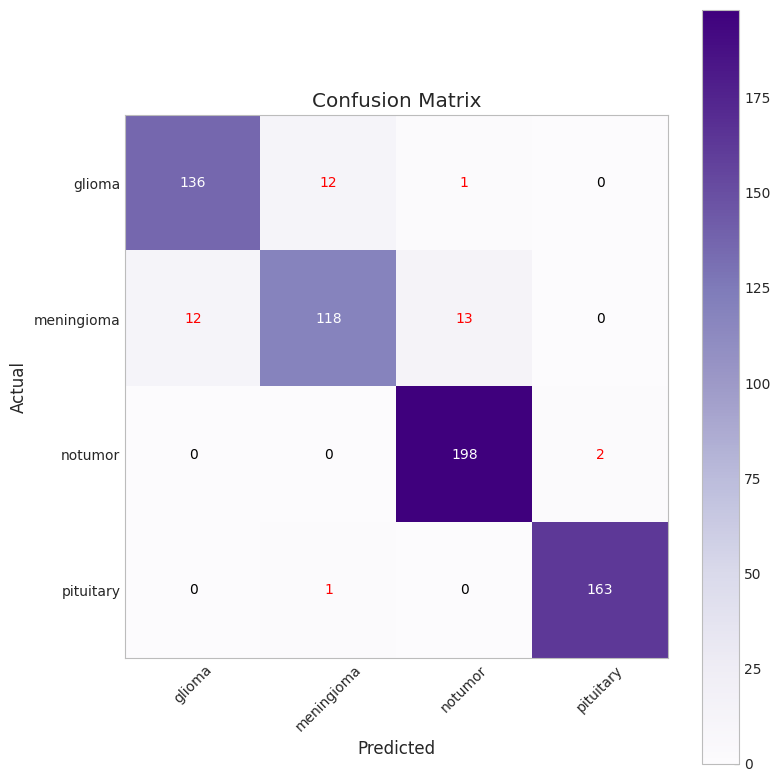

In [43]:
# Use n. of keys of  Class indices to greate confusion matrix
Test_cl_ind = test.class_indices
 
# Get Keys
classes = list(Test_cl_ind.keys())

cm = confusion_matrix(test.classes, y_pred)

plt.figure(figsize =(8, 8))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes,rotation = 45)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if cm[i, j] == 0:
        text_color = 'black'  # black for zero values
    elif i == j:
        text_color = 'white'  # white for diagonal (correct classifications)
    else:
        text_color = 'red'    # red for misclassifications

    plt.text(j, i, cm[i, j],
             horizontalalignment='center',
             verticalalignment='center',
             color=text_color)

plt.grid(False)
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Classification Report (Precision, Recall, F1-Score, Accuracy Metrics)

In [44]:
print(classification_report(test.classes, y_pred, target_names = classes))

              precision    recall  f1-score   support

      glioma       0.92      0.91      0.92       149
  meningioma       0.90      0.83      0.86       143
     notumor       0.93      0.99      0.96       200
   pituitary       0.99      0.99      0.99       164

    accuracy                           0.94       656
   macro avg       0.94      0.93      0.93       656
weighted avg       0.94      0.94      0.94       656



## Save Model

In [45]:
CNN.save("model.keras")

# Load Model (Test Case)

In [46]:
# load model
CNN = tf.keras.models.load_model("model.keras", compile=False)
CNN.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001), 
            loss='categorical_crossentropy', 
            metrics=['accuracy'])

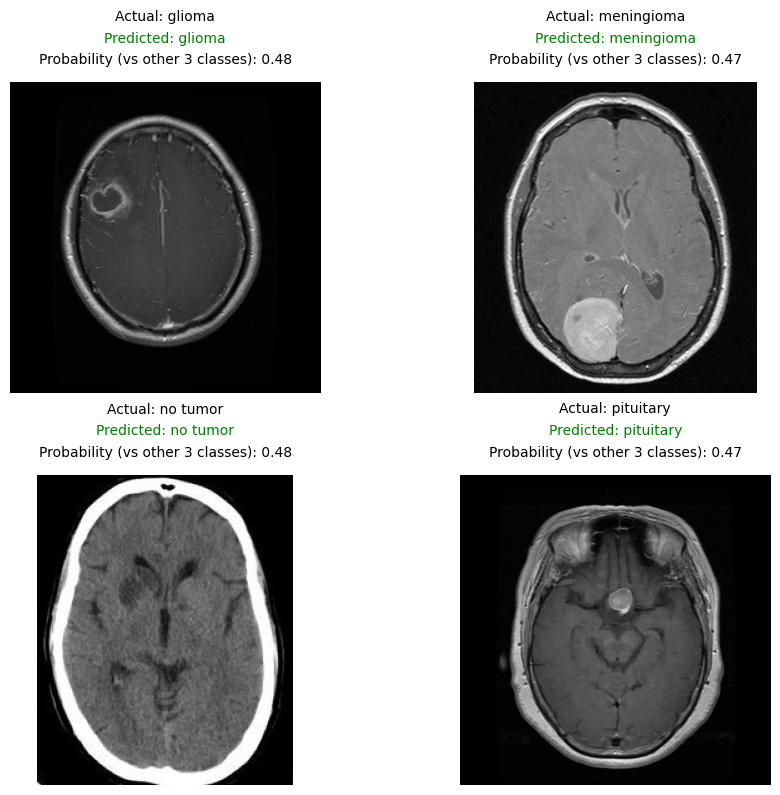

In [47]:
# imports if we loaded this independently (inside web app)
from PIL import Image # instead of openCV since simpler tasks
import tensorflow as tf
import numpy as np

# paths to images from each class
image_paths = {
    'glioma': '/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-gl_0025.jpg',
    'meningioma': '/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0010.jpg',
    'no tumor': '/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-no_0010.jpg',
    'pituitary': '/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-pi_0040.jpg'
}

# initializations
plt.figure(figsize=(10, 8))
class_labels = ['glioma', 'meningioma', 'no tumor', 'pituitary']

for i, (label, path) in enumerate(image_paths.items()):
    img = Image.open(path)
    img_resized = img.resize((224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img_resized)
    img_array = np.expand_dims(img_array, axis=0)  # expand dimensions to fit model input

    # predict and process the results
    predictions = CNN.predict(img_array, verbose=0) # verbose at 0 to prevent status plot
    score = tf.nn.softmax(predictions[0])
    predicted_class = class_labels[np.argmax(score)]

    # plot
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.axis('off')

    # title
    actual_text = f'Actual: {label}'
    predicted_text = f'Predicted: {predicted_class}'
    probability_text = f'Probability (vs other 3 classes): {np.max(score):.2f}'
    
    # title formatting
    spacing = 0.02
    plt.text(0.5, 1.15 + 2*spacing, actual_text, ha='center', va='bottom', transform=plt.gca().transAxes, fontsize='medium', color='black')
    plt.text(0.5, 1.10 + spacing, predicted_text, ha='center', va='bottom', transform=plt.gca().transAxes, fontsize='medium', color='green')
    plt.text(0.5, 1.05, probability_text, ha='center', va='bottom', transform=plt.gca().transAxes, fontsize='medium', color='black')

plt.tight_layout()
plt.show()